## AutoEncoder is a useful tool to perform anomaly detection.
## Even though it is an unsupervised learning, but it is still very useful for extreme imbalanced datset.
## The strategy for auto-encoder anomaly detection is training the auto-encoder by normal samples and calculate the reconstruction error for both normal and fraud samples. If fraud samples are truely different from normal samples, then the construction error of fraud samples will be much bigger than normal samples. So based on a threshold, we can predict fraud data with big reconstruction error. 
## However, we do not have to throw the labels, my strategy is using the reconstruction error as a new feature in any classifier like RF, Xgb or DNN. The pros is it is a very good predictor, the cons is it may cause overfitting. Since it contains the information from other features.
## I have two options to train the autoencoder: 1. Take each sample as iid, then I lose pattern or structure of sequential information. 2. Use transaction date time as time step, use LSTM layer instead of dense layer to build up autoencoder. I will leave that RNN model in DNN file, here I just use dense layer autoencoder.
## My current work is not only detect fraud or suspicious single transaction, but detect the suspicious customers, which means we need to detect the pattern of a collection of transactions instead. In other words, a collection of transactions under a customer can indicate the financial behavior pattern of a customer, where I use many advanced NLP methods, I will use topic model in DNN file to detect customer behavior.   

In [ ]:
Actually, I will use LSTM in DNN files, where the structure of the Neural network is similar, where I create a many to many sequential RNN with LSTM unit  

In [1]:
import pickle
import numpy as np
with open('data.pickle','rb') as load:
    data=pickle.load(load)
#with open('x_train_le.pickle','rb') as load:
#    x_train_le=pickle.load(load)
with open('x_train_ohe.pickle','rb') as load:
    x_train_ohe=pickle.load(load)
with open('le.pickle','rb') as load:
    le=pickle.load(load)
with open('ohe.pickle','rb') as load:
    ohe=pickle.load(load)
with open('y.pickle','rb') as load:
    y=pickle.load(load)
with open('train_test_index.pickle','rb') as load:
    train_test_index=pickle.load(load)
with open('feature_final.pickle','rb') as load:
    feature_final=pickle.load(load)
y_train=y[train_test_index['y_train']]

D:\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator OrdinalEncoder from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=10, random_state=0)
x_train_svd=svd.fit_transform(x_train_ohe)

In [5]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
std.fit_transform(x_train_svd)

array([[ 0.0850474 ,  1.06235103, -0.35282257, ..., -1.14689396,
        -0.14619804,  0.61917983],
       [-0.72185016,  0.00982494, -0.52886104, ..., -1.20188464,
        -0.3288372 ,  0.25929149],
       [ 2.97658613, -3.47007177, -1.11645041, ..., -0.79408673,
        -0.49250003, -0.69893699],
       ...,
       [-0.84295886,  0.08864087, -0.39159828, ..., -0.0367077 ,
        -0.03746106, -0.25532104],
       [ 3.67270497,  1.53233692, -0.60130737, ..., -0.45488904,
        -0.14354081, -1.37420545],
       [ 0.22465498, -1.09832474, -0.63889322, ..., -1.85429309,
        -0.40033283, -0.31680862]])

## I only use normal data to train the auto-encoder, not all data!
## This will be better than use entire data to train the autoencoder!
## seperate normal data and fraud data now!

### The feature processing includs ordinal encoding, onehot encoding, dimension deduction, normalization(standardization)
### Create a pipeline to process it in a second!

In [6]:
class pipeline:
    def __init__(self, init_estimator):
        self.estimator_list=[]
        self.estimator_list.extend(init_estimator)
    
    def add_estimator(self,estimator):# the adding order must be ordinal_encoding, one-hot, SVD, normalize 
        self.estimator_list.extend(estimator)
        
    def feature_encoding(self,df,categorical_feat,interval_feat):
        if len(self.estimator_list)>=2:
            le_array=self.estimator_list[0].transform(df[categorical_feat])
            le_array=np.append(le_array,np.array(df[interval_feat]),axis=1)
            ohe_sparse=self.estimator_list[1].transform(le_array)
            return ohe_sparse 
        else:
            raise ValueError

    def feature_processing(self,df,categorical_feat,interval_feat):
        if len(self.estimator_list)>=4:
            ohe_sparse=self.feature_encoding(df,categorical_feat,interval_feat)
            svd_array=self.estimator_list[2].transform(ohe_sparse)
            std_array=self.estimator_list[3].transform(svd_array)
            return std_array
        else:
            raise ValueError

In [7]:
pip=pipeline([le,ohe,svd,std])

In [8]:
## select normal data to train autoencoder
x_train_normal=data.iloc[y_train[y_train==False].index]
x_train_fraud=data.iloc[y_train[y_train==True].index]
categorical_feat=feature_final[:22]
interval_feat=feature_final[22:]

In [9]:
x_train_normal=pip.feature_processing(x_train_normal,categorical_feat,interval_feat)
x_train_fraud=pip.feature_processing(x_train_fraud,categorical_feat,interval_feat)

In [10]:
####Train-Dense-layer###
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import TensorBoard
n_features =  x_train_svd.shape[1]
epochs = 20
batch = 64
lr = 0.001
hidden_unit_1=50
hidden_unit_2=10
auto_encoder = Sequential()
# Encoder 
auto_encoder.add(Dense(hidden_unit_1, activation='relu', input_shape=(n_features,)))
auto_encoder.add(Dense(hidden_unit_2, activation='relu'))
# Decoder
auto_encoder.add(Dense(hidden_unit_2, activation='relu'))
auto_encoder.add(Dense(hidden_unit_1, activation='relu'))
auto_encoder.add(Dense(n_features, activation='linear'))
auto_encoder.summary()

Using TensorFlow backend.
W0928 23:24:48.995566 15372 deprecation_wrapper.py:119] From D:\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0928 23:24:49.010699 15372 deprecation_wrapper.py:119] From D:\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0928 23:24:49.012666 15372 deprecation_wrapper.py:119] From D:\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
Total params: 6,270
Trainable params: 6,270
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
###optim
auto_encoder.compile(loss='mse', optimizer=optimizers.Adam(lr))
##earlystoping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2)
mc=ModelCheckpoint('best_auto.h5',monitor='val_loss',mode='auto',verbose=1,save_best_only=True)
###training
auto_encoder_history = auto_encoder.fit(x_train_normal, x_train_normal, epochs=epochs,validation_split=0.2,
                                        batch_size=batch,verbose=1,callbacks=[es,mc]).history

W0928 23:24:49.096017 15372 deprecation_wrapper.py:119] From D:\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0928 23:24:49.189595 15372 deprecation_wrapper.py:119] From D:\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0928 23:24:49.308737 15372 deprecation_wrapper.py:119] From D:\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 403591 samples, validate on 100898 samples
Epoch 1/20
403591/403591 [==============================] - 17s 41us/step - loss: 0.6067 - val_loss: 0.4962

Epoch 00001: val_loss improved from inf to 0.49620, saving model to best_auto.h5
Epoch 2/20
403591/403591 [==============================] - 14s 36us/step - loss: 0.4656 - val_loss: 0.4412

Epoch 00002: val_loss improved from 0.49620 to 0.44116, saving model to best_auto.h5
Epoch 3/20
403591/403591 [==============================] - 16s 39us/step - loss: 0.4063 - val_loss: 0.3818

Epoch 00003: val_loss improved from 0.44116 to 0.38184, saving model to best_auto.h5
Epoch 4/20
403591/403591 [==============================] - 16s 40us/step - loss: 0.3660 - val_loss: 0.3544

Epoch 00004: val_loss improved from 0.38184 to 0.35438, saving model to best_auto.h5
Epoch 5/20
403591/403591 [==============================] - 15s 37us/step - loss: 0.3347 - val_loss: 0.3272

Epoch 00005: val_loss improved from 0.35438 to 0.32720, saving mode

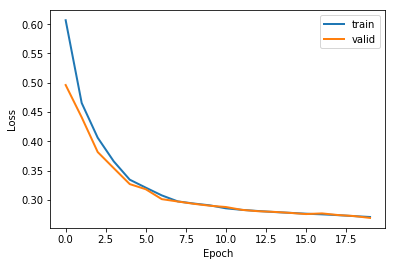

In [12]:
## Consider the limited time, I only train 10 epoches!
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(auto_encoder_history['loss'], linewidth=2, label='train')
plt.plot(auto_encoder_history['val_loss'], linewidth=2, label='valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
predict_normal=auto_encoder.predict(x_train_normal)
mse_normal=np.mean(np.power( predict_normal - x_train_normal, 2),axis=1) 

In [14]:
predict_fraud=auto_encoder.predict(x_train_fraud)
mse_fraud=np.mean(np.power( predict_fraud - x_train_fraud, 2),axis=1) 

In [15]:
import pandas as pd
from sklearn.utils import shuffle
## Compare the reconstruct-error
error_df=pd.DataFrame({'Recons_error':mse_normal,'isFraud':0})
error_df=pd.concat([error_df,pd.DataFrame({'Recons_error':mse_fraud,'isFraud':1})],axis=0)
error_df = shuffle(error_df)
error_df=pd.DataFrame({'Recons_error':error_df['Recons_error'].values,'isFraud':error_df['isFraud'].values})

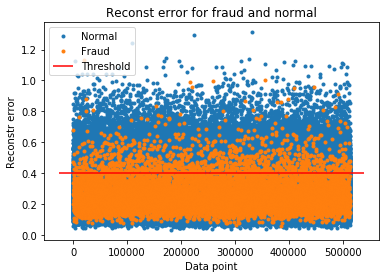

In [16]:
threshold_fixed = 0.4
groups = error_df.groupby('isFraud')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Recons_error, marker='o', ms=3.0, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconst error for fraud and normal")
plt.ylabel("Reconstr error")
plt.xlabel("Data point")
plt.show()

## It looks like the reconstrction error of normal data is not apparently less than the reconstrction error of normal data!
## Notice above data is training data, What about in the totally new testing dataset? Let's take a look!

In [17]:
## testing
y_test=y[train_test_index['y_test']]
x_test_normal=data.iloc[y_test[y_test==False].index]
x_test_fraud=data.iloc[y_test[y_test==True].index]
x_test_normal=pip.feature_processing(x_test_normal,categorical_feat,interval_feat)
x_test_fraud=pip.feature_processing(x_test_fraud,categorical_feat,interval_feat)

In [18]:
predict_normal=auto_encoder.predict(x_test_normal)
mse_normal=np.mean(np.power( predict_normal - x_test_normal, 2),axis=1) 
predict_fraud=auto_encoder.predict(x_train_fraud)
mse_fraud=np.mean(np.power( predict_fraud - x_train_fraud, 2),axis=1) 

In [19]:
error_df=pd.DataFrame({'Recons_error':mse_normal,'isFraud':0})
error_df=pd.concat([error_df,pd.DataFrame({'Recons_error':mse_fraud,'isFraud':1})],axis=0)
error_df = shuffle(error_df)
error_df=pd.DataFrame({'Recons_error':error_df['Recons_error'].values,'isFraud':error_df['isFraud'].values})

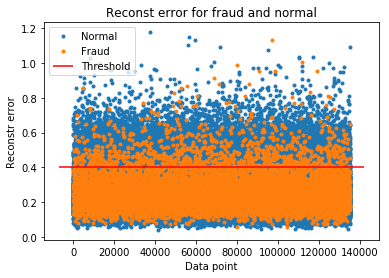

In [20]:
threshold_fixed = 0.4
groups = error_df.groupby('isFraud')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Recons_error, marker='o', ms=3.0, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconst error for fraud and normal")
plt.ylabel("Reconstr error")
plt.xlabel("Data point")
plt.show()

## The reason why the reconstruction error of fraud data is not bigger than normal data is:
## 1. There is no strong relationship between target var with all features
## 2. SVD probably lose some information